<a href="https://colab.research.google.com/github/talitasandrade/TCCPUCMINAS/blob/main/Ocorrencias_Aeronauticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUC Minas - Pontifícia Universidade Católica de Minas Gerais

####  Trabalho de Conclusão de curso
#### Análise e Classificação de Ocorrências Aeronáuticas no Brasil
#### Aluna: Talita Santos Andrade

## Importação de Bibliotecas

In [1]:
# Importação das bibliotecas necessárias para execução do trabalho

In [2]:
#Importação de biblioteca Pandas
import pandas as pd

# Importação de pacotes do sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Importação de pacotes para plotagem de gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Importação de biblioteca Scientific Python
import scipy as sp
from scipy.stats import randint
import random

## Coleta de dados

In [3]:
# Carregamento dos dados dos datasets dentro do DataFrame
df_ocorrencia = pd.read_csv("/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/ocorrencia.csv", sep=';')
df_aeronave = pd.read_csv("/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/aeronave.csv", sep=';')
df_ocorrencia_tipo = pd.read_csv("/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/ocorrencia_tipo.csv", sep=';')

df_fator_contribuinte = pd.read_csv("/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/fator_contribuinte.csv", sep=';')
df_recomendacao = pd.read_csv("/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/recomendacao.csv", sep=';')

In [4]:
# Análise de informações sobre os datasets
df_ocorrencia.info()
df_aeronave.info()
df_ocorrencia_tipo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769 entries, 0 to 6768
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   codigo_ocorrencia               6769 non-null   int64 
 1   codigo_ocorrencia1              6769 non-null   int64 
 2   codigo_ocorrencia2              6769 non-null   int64 
 3   codigo_ocorrencia3              6769 non-null   int64 
 4   codigo_ocorrencia4              6769 non-null   int64 
 5   ocorrencia_classificacao        6769 non-null   object
 6   ocorrencia_latitude             5135 non-null   object
 7   ocorrencia_longitude            5135 non-null   object
 8   ocorrencia_cidade               6769 non-null   object
 9   ocorrencia_uf                   6769 non-null   object
 10  ocorrencia_pais                 6769 non-null   object
 11  ocorrencia_aerodromo            6769 non-null   object
 12  ocorrencia_dia                  6769 non-null   

In [5]:
# Merge entre os dataset ocorrencia, ocorrencia_tipo e aeronave para criar um dataset único para execução do processamento 
# de dados e algorítmo de Machine Learning
df_ocor_ocortipo = pd.merge(df_ocorrencia, df_ocorrencia_tipo, on='codigo_ocorrencia1', how='outer')
df_ocorr_aeronauticas_full = pd.merge(df_ocor_ocortipo, df_aeronave, on='codigo_ocorrencia2', how='outer')
df_ocorr_aeronauticas_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195 entries, 0 to 7194
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   codigo_ocorrencia               7195 non-null   int64  
 1   codigo_ocorrencia1              7195 non-null   int64  
 2   codigo_ocorrencia2              7195 non-null   int64  
 3   codigo_ocorrencia3              7195 non-null   int64  
 4   codigo_ocorrencia4              7195 non-null   int64  
 5   ocorrencia_classificacao        7195 non-null   object 
 6   ocorrencia_latitude             5534 non-null   object 
 7   ocorrencia_longitude            5534 non-null   object 
 8   ocorrencia_cidade               7195 non-null   object 
 9   ocorrencia_uf                   7195 non-null   object 
 10  ocorrencia_pais                 7195 non-null   object 
 11  ocorrencia_aerodromo            7195 non-null   object 
 12  ocorrencia_dia                  71

In [6]:
# Filtro de colunas que serão utilizadas para a aplicação dos modelos de ML, colunas não relevantes para a análise foram filtradas 
# levando em consideração as informações obtidas com a análise de correlação linear e exploração dos dados
df_ocorr_aeronauticas = df_ocorr_aeronauticas_full[['codigo_ocorrencia',
'total_recomendacoes',
'total_aeronaves_envolvidas',
'ocorrencia_saida_pista',
'ocorrencia_tipo',
'ocorrencia_tipo_categoria',
'aeronave_tipo_veiculo',
'aeronave_motor_tipo',
'aeronave_motor_quantidade',
'aeronave_registro_categoria',
'aeronave_registro_segmento',
'aeronave_fase_operacao',
'aeronave_tipo_operacao',
'aeronave_nivel_dano',
'aeronave_fatalidades_total',
'ocorrencia_classificacao']]
df_ocorr_aeronauticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195 entries, 0 to 7194
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codigo_ocorrencia            7195 non-null   int64  
 1   total_recomendacoes          7195 non-null   int64  
 2   total_aeronaves_envolvidas   7195 non-null   int64  
 3   ocorrencia_saida_pista       7195 non-null   object 
 4   ocorrencia_tipo              7194 non-null   object 
 5   ocorrencia_tipo_categoria    7194 non-null   object 
 6   aeronave_tipo_veiculo        6621 non-null   object 
 7   aeronave_motor_tipo          6603 non-null   object 
 8   aeronave_motor_quantidade    6621 non-null   object 
 9   aeronave_registro_categoria  6621 non-null   object 
 10  aeronave_registro_segmento   6621 non-null   object 
 11  aeronave_fase_operacao       6621 non-null   object 
 12  aeronave_tipo_operacao       6621 non-null   object 
 13  aeronave_nivel_dan

In [7]:
# Conta dados nulos para cada coluna do database
df_ocorr_aeronauticas.isnull().sum()

# Conta dados nulos por ano para cada coluna do database

df_ocorr_aeronauticas_null = df_ocorr_aeronauticas.copy()
df_ocorr_aeronauticas_full['ocorrencia_dia'] = pd.to_datetime(df_ocorr_aeronauticas_full['ocorrencia_dia'])
df_ocorr_aeronauticas_null['ano'] = df_ocorr_aeronauticas_full['ocorrencia_dia'].dt.year
df_ocorr_aeronauticas_null
null_counts = df_ocorr_aeronauticas_null.groupby('ano').apply(lambda x: x.isnull().sum())

null_counts.to_excel('/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/Dados-nulos-por-ano.xlsx')

<ipython-input-7-fe306f992846>:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_ocorr_aeronauticas_full['ocorrencia_dia'] = pd.to_datetime(df_ocorr_aeronauticas_full['ocorrencia_dia'])


## Análise dos dados

Gráfico de Boxplot

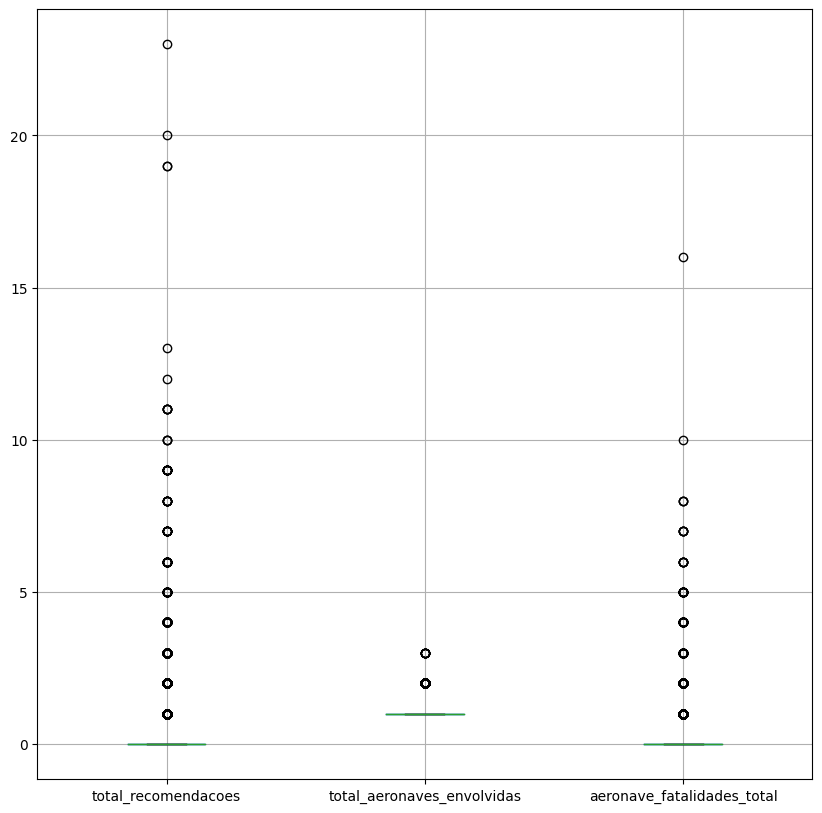

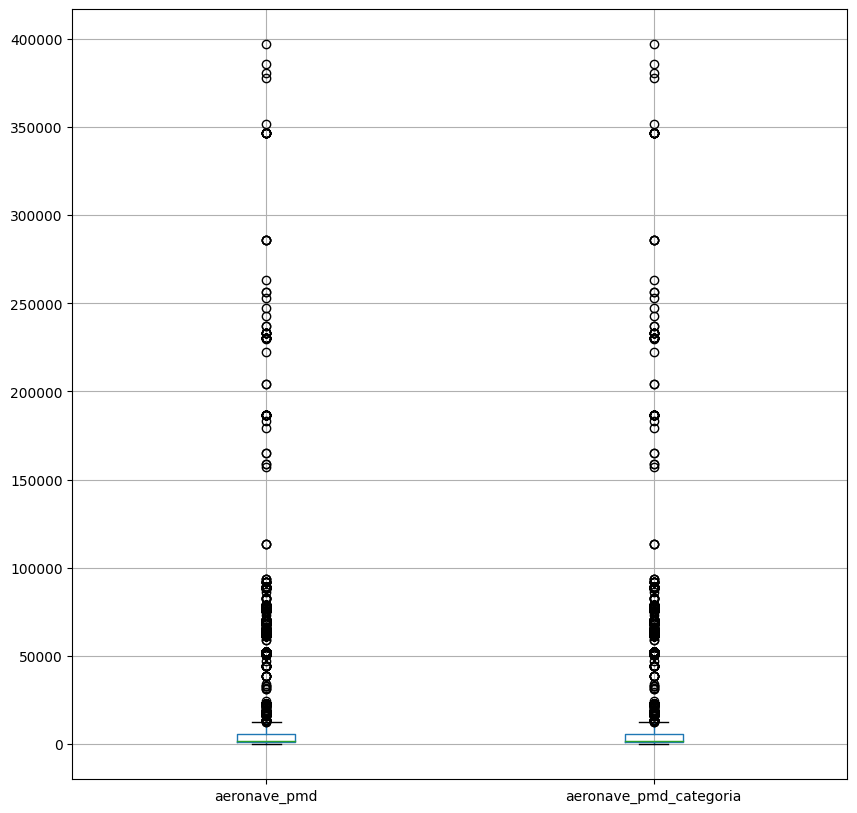

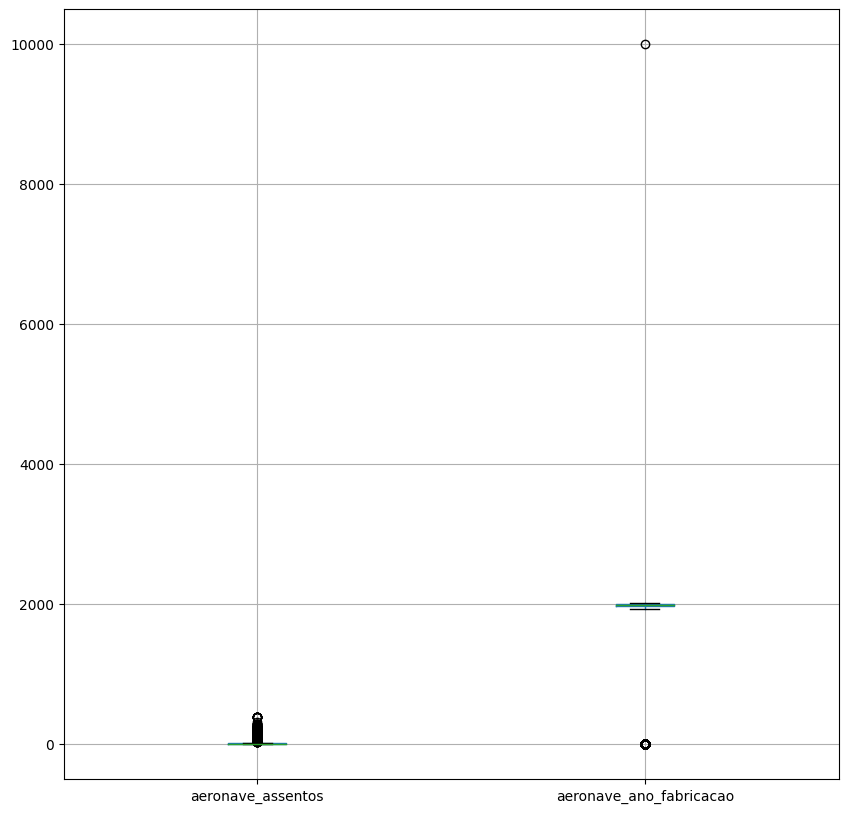

In [8]:
# Gráficos de boxplot para colunas numéricas

# Seleção das colunas numéricas, elas foram segregadas em 3 listas para melhorar a apresentação dos gráficos
cols_boxplot1 = ['total_recomendacoes', 'total_aeronaves_envolvidas', 'aeronave_fatalidades_total']           
cols_boxplot2 = ['aeronave_pmd', 'aeronave_pmd_categoria']  
cols_boxplot3 = ['aeronave_assentos', 'aeronave_ano_fabricacao']


fig, ax = plt.subplots(figsize=(10,10)) #aumentar as dimensões do imagem 
dados_boxplot1 = df_ocorr_aeronauticas_full[cols_boxplot1]
dados_boxplot1.boxplot() #gerar gráfico boxplot
plt.show()

fig, ax = plt.subplots(figsize=(10,10))  #aumentar as dimensões do imagem
dados_boxplot2 = df_ocorr_aeronauticas_full[cols_boxplot2]
dados_boxplot2.boxplot() #gerar gráfico boxplot
plt.show()

fig, ax = plt.subplots(figsize=(10,10))  #aumentar as dimensões do imagem
dados_boxplot3 = df_ocorr_aeronauticas_full[cols_boxplot3]
dados_boxplot3.boxplot() #gerar gráfico boxplot
plt.show()


Gráfico de Correlação

In [9]:
# Seleciona todas as colunas que são de texto
df_categorical = df_ocorr_aeronauticas_full[df_ocorr_aeronauticas_full.select_dtypes(include=['object']).columns]

# Conversão dos dados categóricos em numéricos com o método OrdinalEncoder 
ordinal_encoder = OrdinalEncoder()
data_encoded = ordinal_encoder.fit_transform(df_categorical)
data_encoded = pd.DataFrame(data_encoded, columns=df_categorical.columns)

# Seleciona todas as colunas que são numéricas
df_numerical = df_ocorr_aeronauticas[df_ocorr_aeronauticas.select_dtypes(exclude=['object']).columns]

# Concatena as colunas que passaram pelo processo de conversão e as colunas numéricas para formar um único database
df_corr = pd.concat([data_encoded,df_numerical], axis=1)
df_corr = df_corr.drop('ocorrencia_pais', axis=1) # Retirando coluna país pois a mesma possui um único valor para todo o database

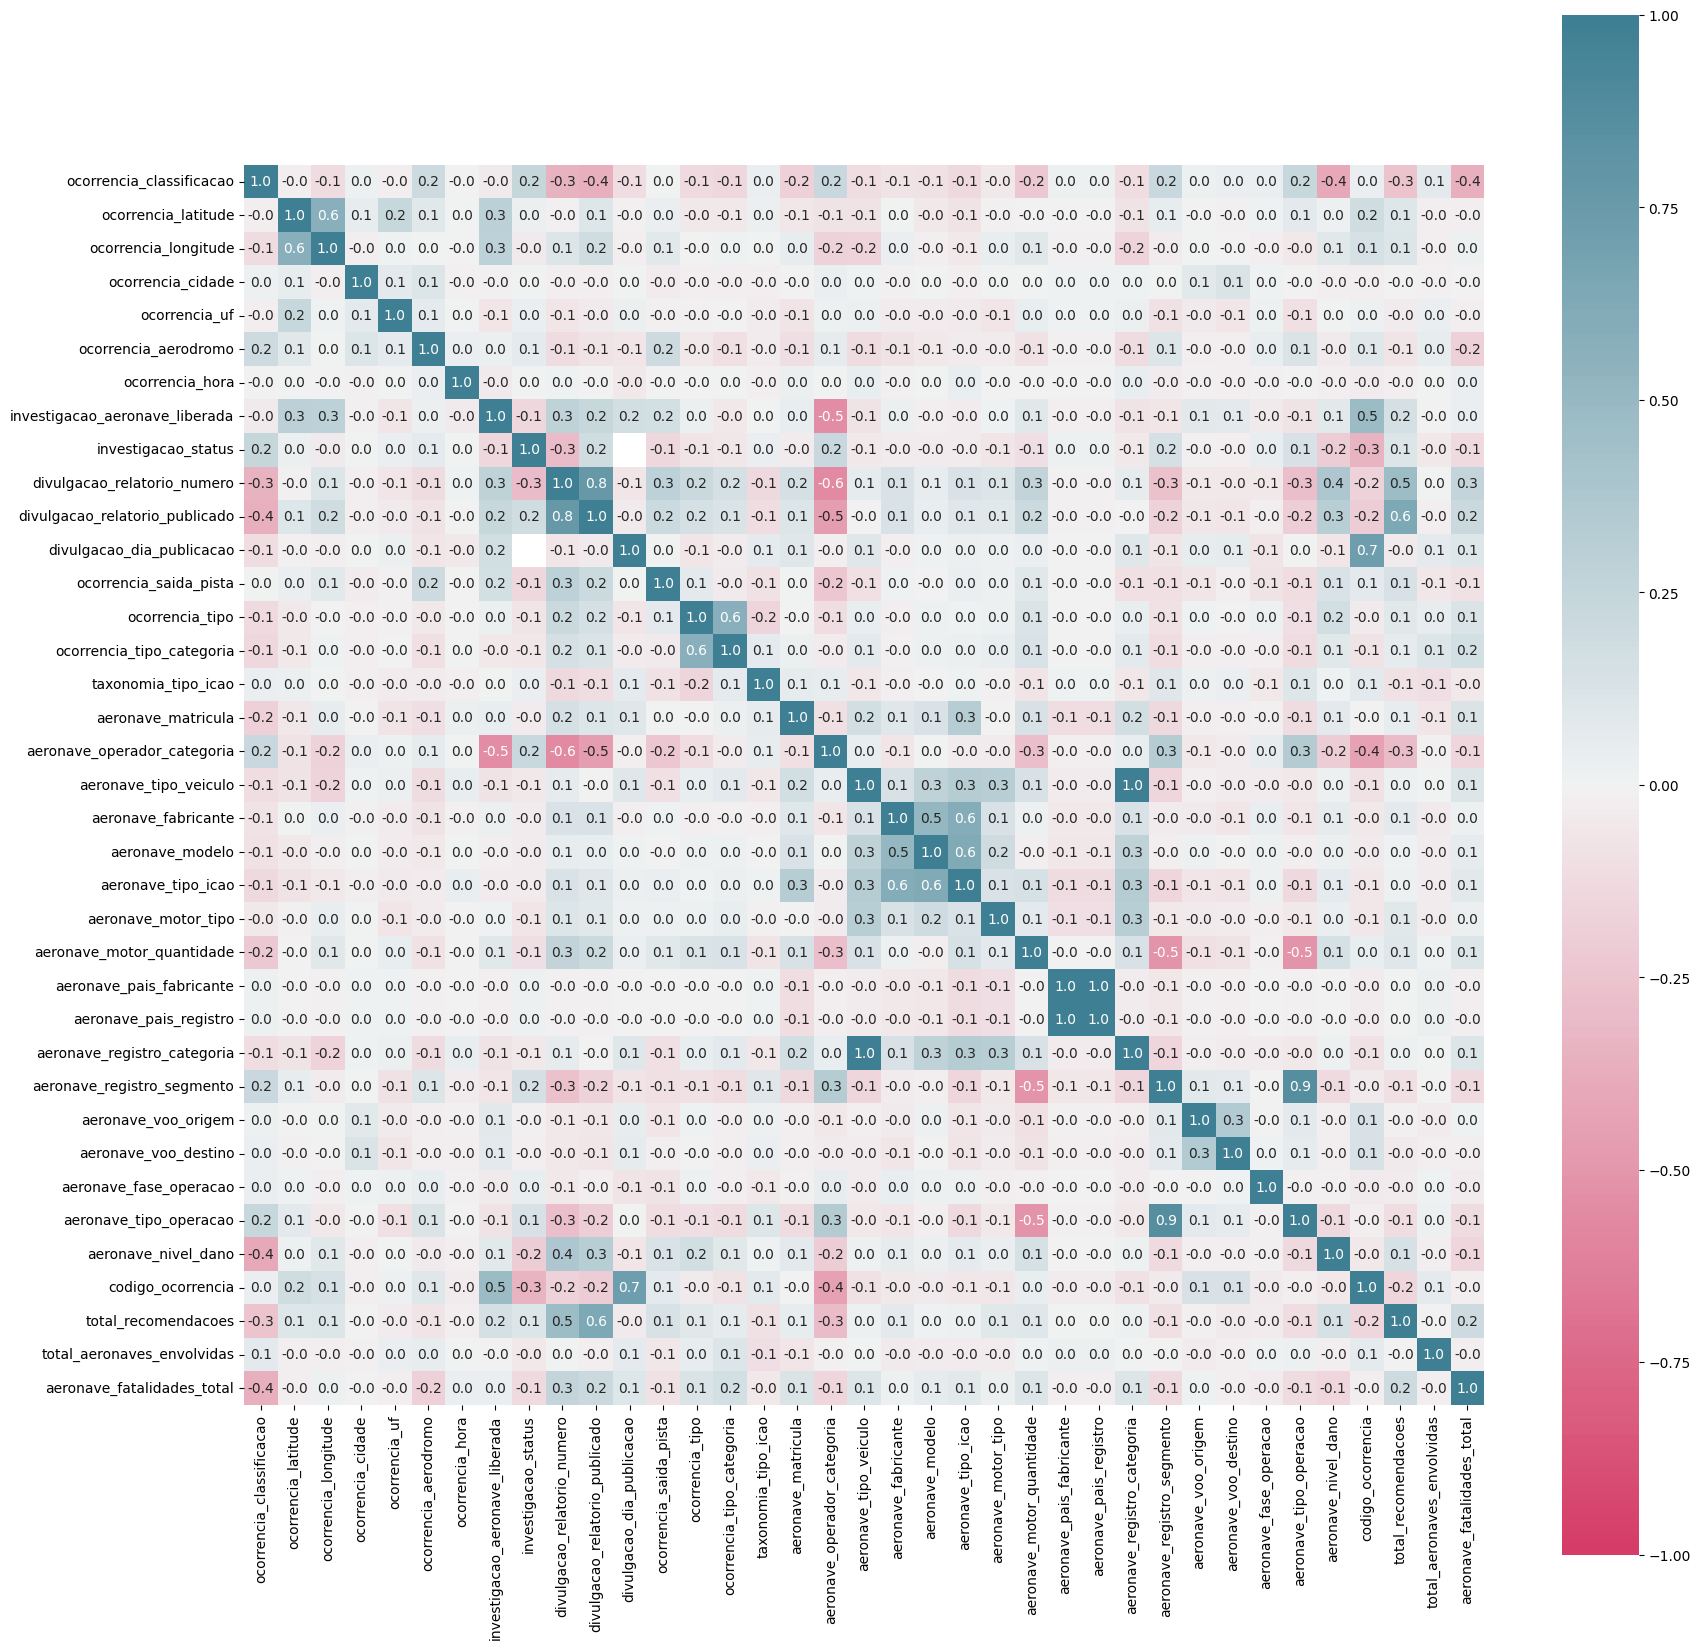

In [10]:
# Calcular a matriz de correlação linear
corr = df_corr.corr(method='spearman')

# Aumentar tamanho da figura
fig, ax = plt.subplots(figsize=(20,20))
# Plotar um heatmap da matriz de correlação
axis_corr = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(1, 220, n=500),
square=True, annot=True, fmt=".1f")

plt.show()

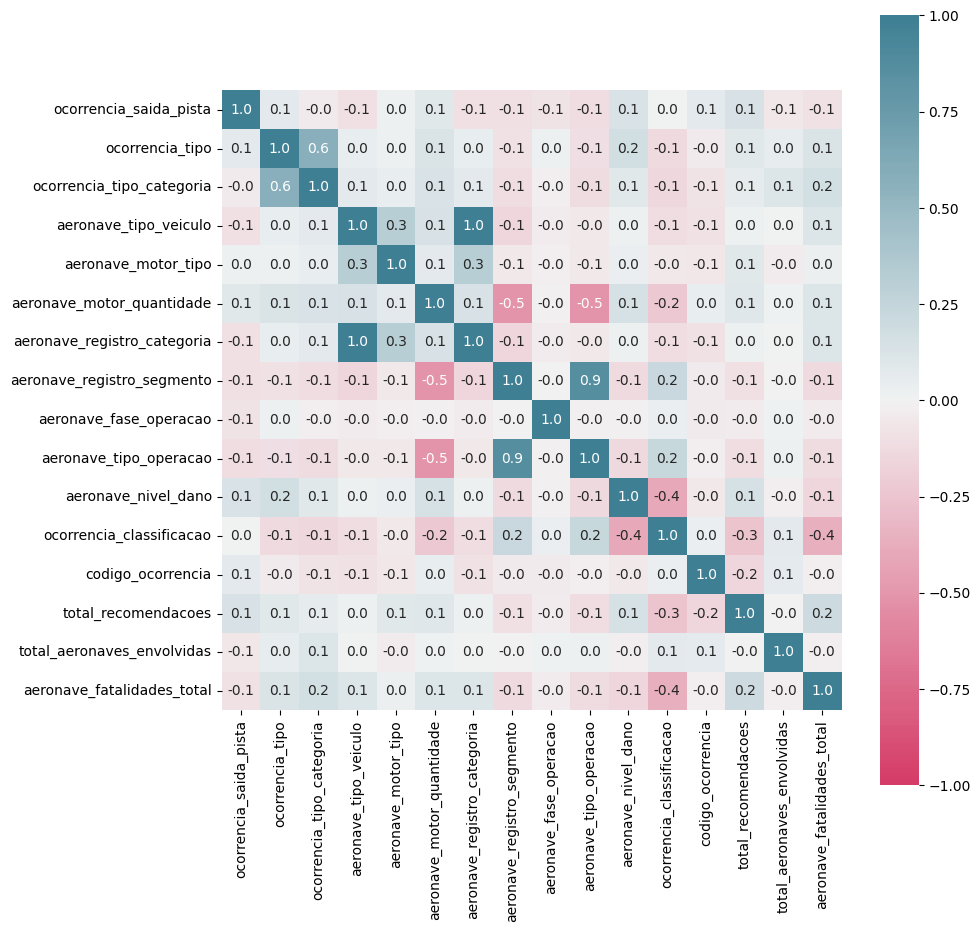

In [11]:
# Seleciona todas as colunas que são de texto
df_categorical = df_ocorr_aeronauticas[df_ocorr_aeronauticas.select_dtypes(include=['object']).columns]

# Conversão dos dados categóricos em numéricos com o método OrdinalEncoder 
ordinal_encoder = OrdinalEncoder()
data_encoded = ordinal_encoder.fit_transform(df_categorical)
data_encoded = pd.DataFrame(data_encoded, columns=df_categorical.columns)

# Seleciona todas as colunas que são numéricas
df_numerical = df_ocorr_aeronauticas[df_ocorr_aeronauticas.select_dtypes(exclude=['object']).columns]

# Concatena as colunas que passaram pelo processo de conversão e as colunas numéricas para formar um único database
df_corr = pd.concat([data_encoded,df_numerical], axis=1)

# Calcular a matriz de correlação linear
corr = df_corr.corr(method='spearman')

# Aumentar tamanho da figura
fig, ax = plt.subplots(figsize=(10,10))
# Plotar um heatmap da matriz de correlação
axis_corr = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(1, 220, n=500),
square=True, annot=True, fmt=".1f")

plt.show()

       codigo_ocorrencia  total_recomendacoes  total_aeronaves_envolvidas  \
count        7195.000000          7195.000000                 7195.000000   
mean        62336.568450             0.322863                    1.027380   
std         15245.212586             1.152471                    0.170693   
min         39115.000000             0.000000                    1.000000   
25%         46999.000000             0.000000                    1.000000   
50%         60697.000000             0.000000                    1.000000   
75%         79049.500000             0.000000                    1.000000   
max         81030.000000            23.000000                    3.000000   

       aeronave_fatalidades_total  
count                 6621.000000  
mean                     0.146201  
std                      0.669635  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  
75%                      0.000000  
max               

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


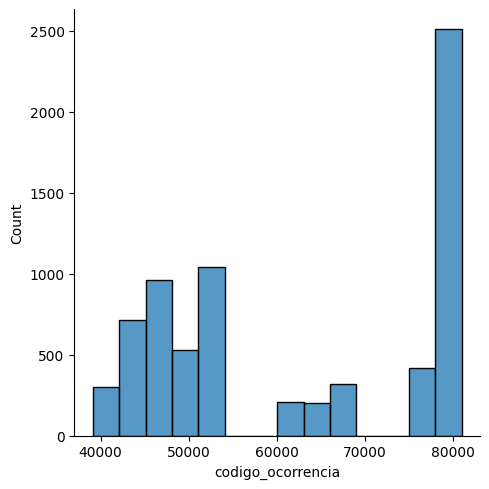

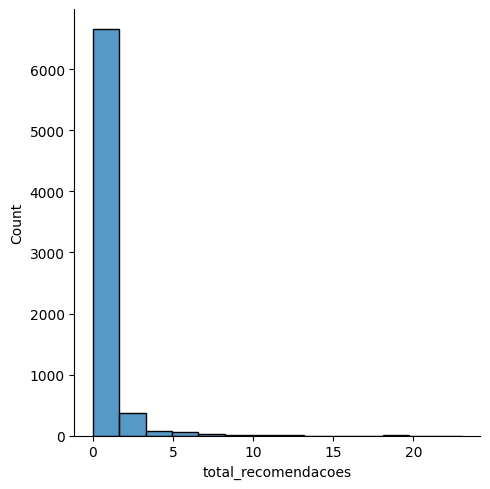

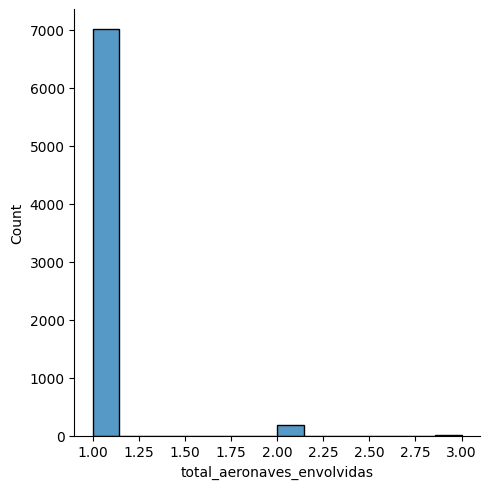

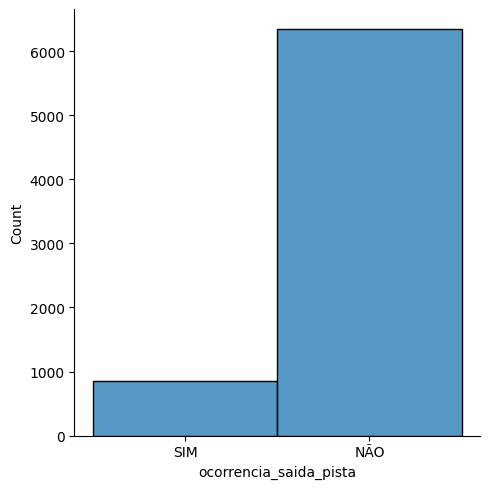

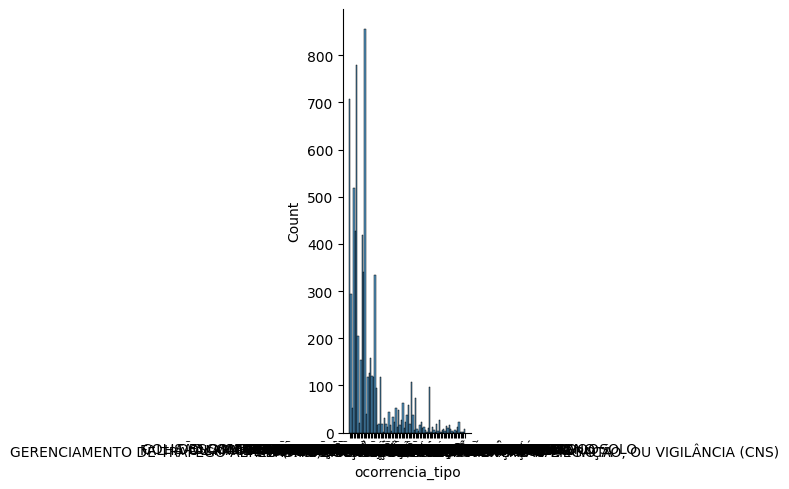

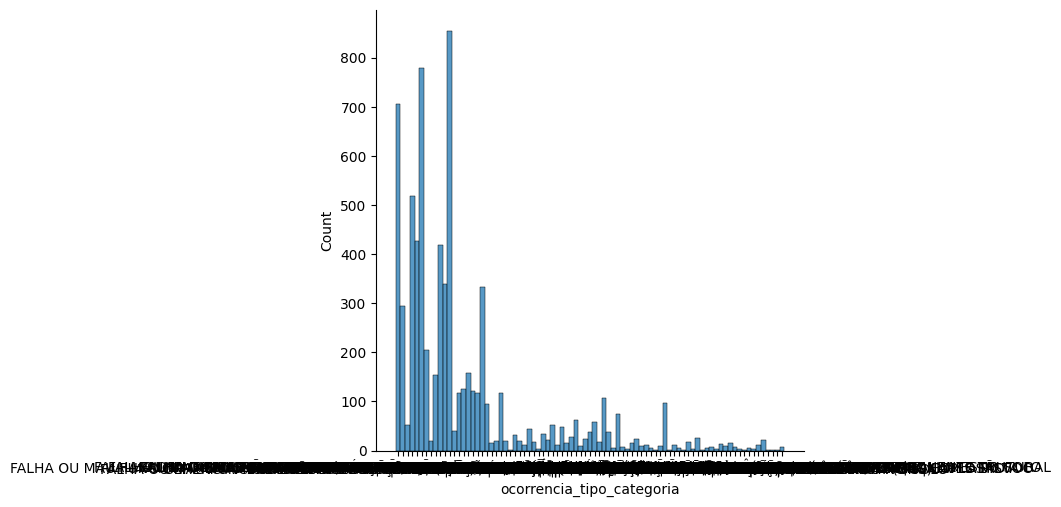

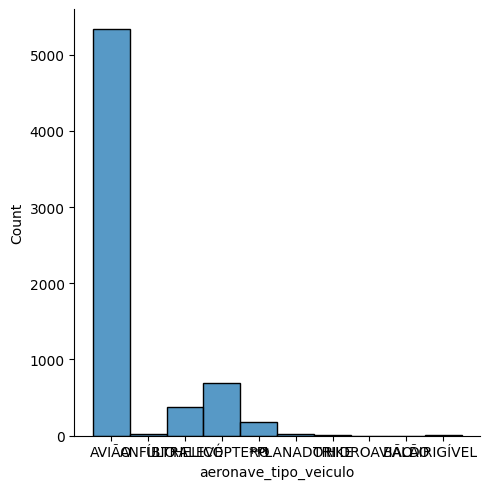

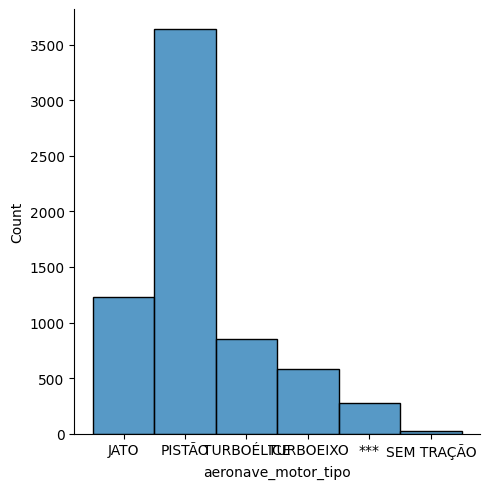

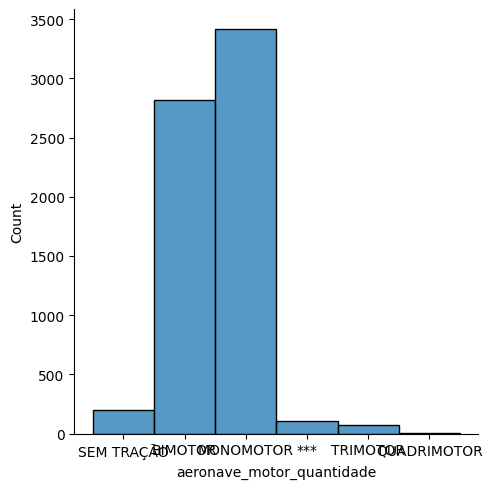

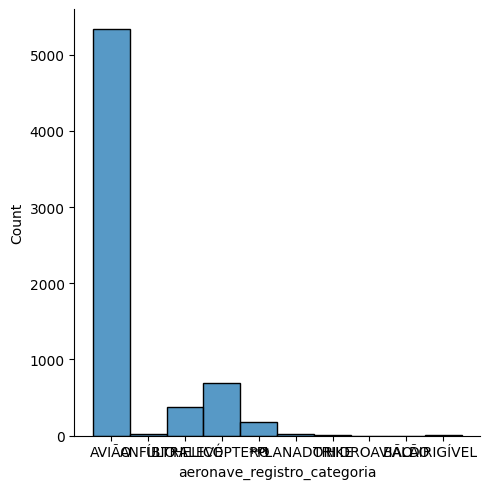

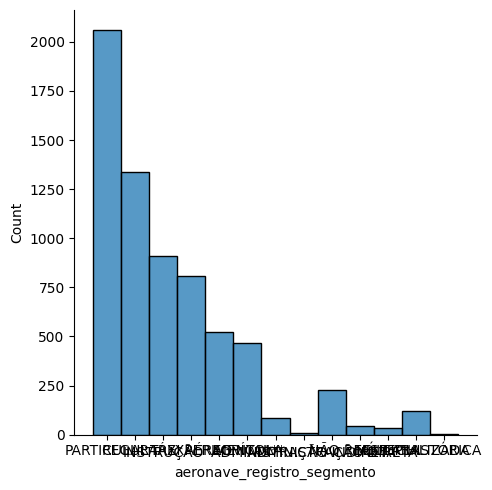

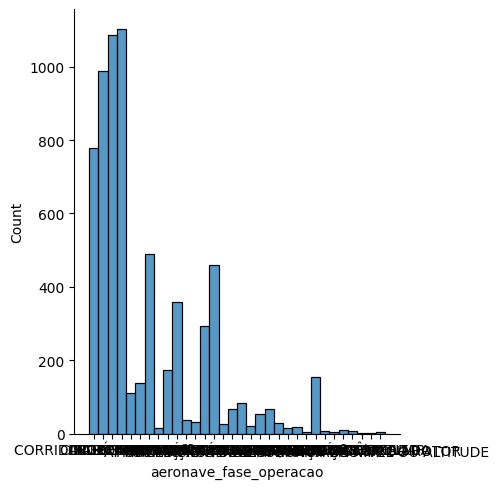

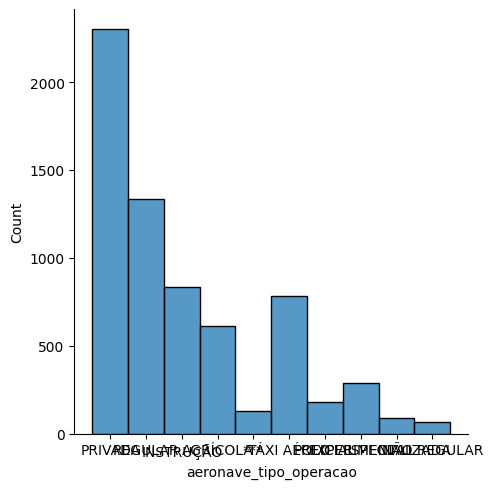

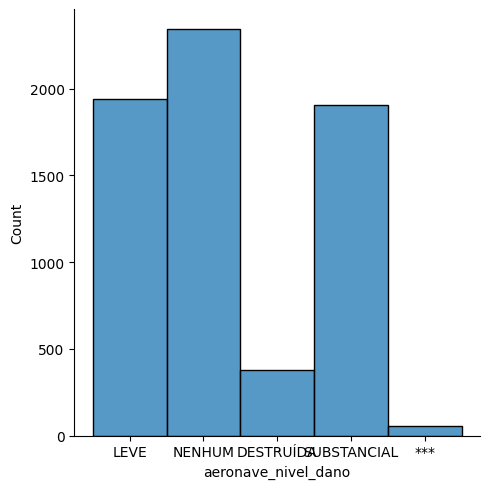

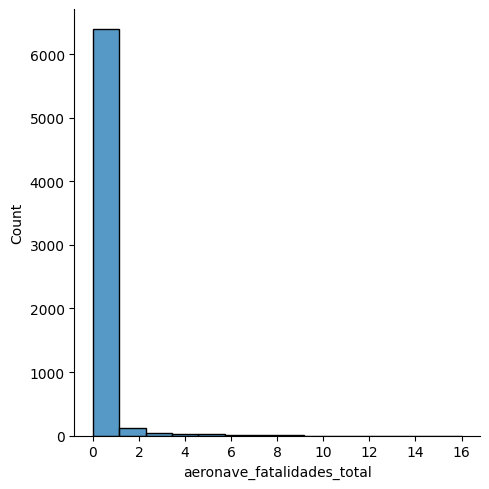

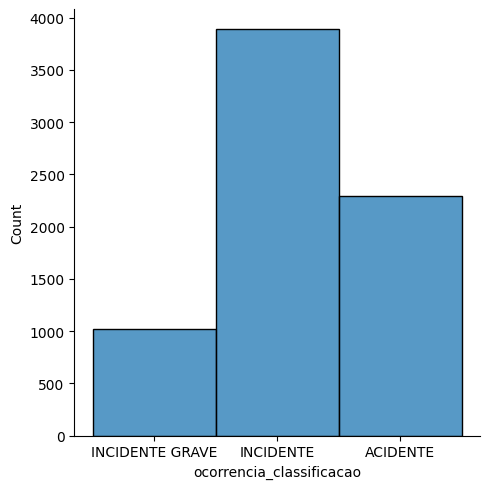

In [12]:
# Obter informações estatísticas do dataset
stats = df_ocorr_aeronauticas.describe()

# Imprimir as informações estatísticas
print(stats)

# Plota o histograma de cada campo
for col in df_ocorr_aeronauticas.columns:
        sns.displot(df_ocorr_aeronauticas[col])
        #df_ocorr_aeronauticas[col].hist()
        #plt.show()

## Processamento do dado 

In [13]:
df_ocorr_aeronauticas_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195 entries, 0 to 7194
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   codigo_ocorrencia               7195 non-null   int64         
 1   codigo_ocorrencia1              7195 non-null   int64         
 2   codigo_ocorrencia2              7195 non-null   int64         
 3   codigo_ocorrencia3              7195 non-null   int64         
 4   codigo_ocorrencia4              7195 non-null   int64         
 5   ocorrencia_classificacao        7195 non-null   object        
 6   ocorrencia_latitude             5534 non-null   object        
 7   ocorrencia_longitude            5534 non-null   object        
 8   ocorrencia_cidade               7195 non-null   object        
 9   ocorrencia_uf                   7195 non-null   object        
 10  ocorrencia_pais                 7195 non-null   object        
 11  ocor

In [14]:
# Conta dados nulos para cada coluna do database
df_ocorr_aeronauticas_full.isnull().sum()

# Conta dados nulos por ano para cada coluna do database
df_ocorr_aeronauticas_full['ocorrencia_dia'] = pd.to_datetime(df_ocorr_aeronauticas_full['ocorrencia_dia'])
df_ocorr_aeronauticas_full['ano'] = df_ocorr_aeronauticas_full['ocorrencia_dia'].dt.year
df_ocorr_aeronauticas_full
null_counts = df_ocorr_aeronauticas_full.groupby('ano').apply(lambda x: x.isnull().sum())

null_counts.to_excel('/content/drive/MyDrive/TCC - Ciência de Dados e Big Data/06-Ocorrencias-Aeronauticas/Dados-nulos-por-ano.xlsx')

In [15]:
count = df_ocorr_aeronauticas.apply(lambda x: x[x=='***'].count())
print(count)

codigo_ocorrencia                0
total_recomendacoes              0
total_aeronaves_envolvidas       0
ocorrencia_saida_pista           0
ocorrencia_tipo                 12
ocorrencia_tipo_categoria       12
aeronave_tipo_veiculo          173
aeronave_motor_tipo            280
aeronave_motor_quantidade      108
aeronave_registro_categoria    173
aeronave_registro_segmento      83
aeronave_fase_operacao          28
aeronave_tipo_operacao         130
aeronave_nivel_dano             57
aeronave_fatalidades_total       0
ocorrencia_classificacao         0
dtype: int64


In [16]:
# Subistituição de valores '***' por texto 'NÃO INFORMADO' para uniformização da base de dados
df_ocorr_aeronauticas = df_ocorr_aeronauticas.replace('***', 'NÃO INFORMADO')

# Subistituição de valores NULOS de colunas com informação do tipo texto por valor 'NÃO INFORMADO' 
df_ocorr_aeronauticas[df_ocorr_aeronauticas.select_dtypes(
    include=['object']).columns] = df_ocorr_aeronauticas.select_dtypes(
        include=['object']).fillna('NÃO INFORMADO')

# Subistituição de valores NULOS da coluna aeronave_fatalidades_total por zero (0) 
df_ocorr_aeronauticas['aeronave_fatalidades_total'] = df_ocorr_aeronauticas['aeronave_fatalidades_total'].fillna(0)
df_ocorr_aeronauticas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7195 entries, 0 to 7194
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codigo_ocorrencia            7195 non-null   int64  
 1   total_recomendacoes          7195 non-null   int64  
 2   total_aeronaves_envolvidas   7195 non-null   int64  
 3   ocorrencia_saida_pista       7195 non-null   object 
 4   ocorrencia_tipo              7195 non-null   object 
 5   ocorrencia_tipo_categoria    7195 non-null   object 
 6   aeronave_tipo_veiculo        7195 non-null   object 
 7   aeronave_motor_tipo          7195 non-null   object 
 8   aeronave_motor_quantidade    7195 non-null   object 
 9   aeronave_registro_categoria  7195 non-null   object 
 10  aeronave_registro_segmento   7195 non-null   object 
 11  aeronave_fase_operacao       7195 non-null   object 
 12  aeronave_tipo_operacao       7195 non-null   object 
 13  aeronave_nivel_dan

In [17]:
# Normalização dos dados numéricos
# Selecionar apenas as colunas numéricas que deseja normalizar
cols_to_normalize = ['total_recomendacoes', 'total_aeronaves_envolvidas', 'aeronave_fatalidades_total']

# Cria uma instância do objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica a normalização min-max nas colunas selecionadas
df_ocorr_aeronauticas[cols_to_normalize] = scaler.fit_transform(df_ocorr_aeronauticas[cols_to_normalize])


In [18]:
#impressão da tabela após normalização dos dados
df_ocorr_aeronauticas

,codigo_ocorrencia,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_tipo,ocorrencia_tipo_categoria,aeronave_tipo_veiculo,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,ocorrencia_classificacao
0,81027,0.0,0.0,SIM,ESTOURO DE PNEU,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,AVIÃO,JATO,SEM TRAÇÃO,AVIÃO,PARTICULAR,CORRIDA APÓS POUSO,PRIVADA,LEVE,0.0,INCIDENTE GRAVE
1,81027,0.0,0.0,SIM,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,AVIÃO,JATO,SEM TRAÇÃO,AVIÃO,PARTICULAR,CORRIDA APÓS POUSO,PRIVADA,LEVE,0.0,INCIDENTE GRAVE
2,81030,0.0,0.0,NÃO,DESCOMPRESSÃO NÃO INTENCIONAL / EXPLOSIVA,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,AVIÃO,JATO,BIMOTOR,AVIÃO,REGULAR,CRUZEIRO,REGULAR,NENHUM,0.0,INCIDENTE
3,81023,0.0,0.0,SIM,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,AVIÃO,PISTÃO,MONOMOTOR,AVIÃO,INSTRUÇÃO,DECOLAGEM,INSTRUÇÃO,LEVE,0.0,INCIDENTE GRAVE
4,81023,0.0,0.0,SIM,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,AVIÃO,PISTÃO,MONOMOTOR,AVIÃO,INSTRUÇÃO,DECOLAGEM,INSTRUÇÃO,LEVE,0.0,INCIDENTE GRAVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,40324,0.0,0.0,NÃO,OUTROS,OUTROS,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,0.0,INCIDENTE
7191,39527,0.0,0.0,NÃO,OPERAÇÃO A BAIXA ALTITUDE,OPERAÇÃO A BAIXA ALTITUDE,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,0.0,ACIDENTE
7192,40211,0.0,0.0,NÃO,TRÁFEGO AÉREO,PERDA DE SEPARAÇÃO / COLISÃO EM VOO | TRÁFEGO ...,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,0.0,INCIDENTE
7193,40349,0.0,0.0,NÃO,COLISÃO COM AVE,COLISÃO COM AVE,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,0.0,INCIDENTE


## Modelos de Machine Learning

In [19]:
# Separar os dados de entrada (features) e saída (target)
X = df_ocorr_aeronauticas.drop('ocorrencia_classificacao', axis=1)
y = df_ocorr_aeronauticas['ocorrencia_classificacao']

# Aplicar One-Hot Encoding nas colunas categóricas
categorical_columns = ['ocorrencia_saida_pista', 'ocorrencia_tipo','ocorrencia_tipo_categoria', 
                       'aeronave_tipo_veiculo','aeronave_motor_tipo','aeronave_motor_quantidade',
                       'aeronave_registro_categoria','aeronave_registro_segmento','aeronave_fase_operacao',
                       'aeronave_tipo_operacao','aeronave_nivel_dano']
ohe = OneHotEncoder()
X_categorical = ohe.fit_transform(X[categorical_columns])

# Concatenar as colunas numéricas e categóricas
X_numerical = X.drop(columns=categorical_columns)
X_encoded = sp.sparse.hstack([X_numerical, X_categorical])

### Execução do modelo de classificação Random Forest

Usando hiperparâmetros padrão

In [20]:
# Criar um modelo Random Forest com 100 árvores
rf_model = RandomForestClassifier()

# Fazer a validação cruzada do modelo e obter as previsões
y_pred_rf = cross_val_predict(rf_model, X_encoded, y, cv=10)

# Aplicar o cross validation
scores_rf = cross_val_score(rf_model, X_encoded, y, cv=10)

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))

Accuracy: 0.88 (+/- 0.08)


Configurando hiperparâmetros

In [ ]:
# Definir o espaço de hiperparâmetros
param_dist = {
    'n_estimators': randint(10, 500),
    'max_depth': [ None], #5, 8, 9, 10, 15,
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': [ 'sqrt', 'log2']
}

# Criar o modelo de Random Forest
rf_model = RandomForestClassifier()

# Realizar a busca aleatória
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv= 10,
                                   n_iter=20, scoring='accuracy', random_state=10)
random_search.fit(X_encoded, y)

# Obter os melhores hiperparâmetros encontrados
best_params = random_search.best_params_

# Treinar o modelo com os melhores hiperparâmetros
rf_model_best = RandomForestClassifier(**best_params)

# Fazer a validação cruzada do modelo e obter as previsões
y_pred_rf = cross_val_predict(rf_model_best, X_encoded, y, cv=10)

# Aplicar o cross validation
scores_rf = cross_val_score(rf_model_best, X_encoded, y, cv=10)

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rf.mean(), scores_rf.std() * 2))


In [ ]:
# Imprimir os melhores parâmetros encontrados
print("Melhores Parâmetros:")
print(random_search.best_params_)

# Imprimir a melhor pontuação
print("Melhor Pontuação:")
print(random_search.best_score_)

### Execução do modelo de classificação Decision Tree

Usando hiperparâmetros padrão

In [ ]:
# Criar modelo de Árvore de Decisão
dt_model = DecisionTreeClassifier()

# Fazer a validação cruzada e obter as previsões
y_pred_dt = cross_val_predict(dt_model, X_encoded, y, cv=10)

# Aplicar o cross validation
scores_dt = cross_val_score(dt_model, X_encoded, y, cv=10)

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_dt.mean(), scores_dt.std() * 2))

Configurando hiperparâmetros

In [ ]:
# Definir o espaço de hiperparâmetros
param_dist = {
    'max_depth': [ None], 
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': [ 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random']
}

# Criar o modelo de Random Forest
dt_model = DecisionTreeClassifier()

# Realizar a busca aleatória
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, cv= 10,
                                   n_iter=20, scoring='accuracy', random_state=10)
random_search.fit(X_encoded, y)

# Obter os melhores hiperparâmetros encontrados
best_params = random_search.best_params_

# Treinar o modelo com os melhores hiperparâmetros
dt_model_best = DecisionTreeClassifier(**best_params)

# Fazer a validação cruzada do modelo e obter as previsões
y_pred_dt = cross_val_predict(dt_model_best, X_encoded, y, cv=10)

# Aplicar o cross validation
scores_dt = cross_val_score(dt_model_best, X_encoded, y, cv=10)

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_dt.mean(), scores_dt.std() * 2))

In [ ]:
# Imprimir os melhores parâmetros encontrados
print("Melhores Parâmetros:")
print(random_search.best_params_)

# Imprimir a melhor pontuação
print("Melhor Pontuação:")
print(random_search.best_score_)

### Execução do modelo de classificação Gradient Boosted

Usando hiperparâmetros padrão

In [ ]:
# Definir o modelo de Gradient Boosted com hiperparâmetros padrão
gb_model = GradientBoostingClassifier()

# Fazer as previsões com Cross Validation
y_pred_gb = cross_val_predict(gb_model, X_encoded, y, cv=10)

# Calcular o score com Cross Validation
scores_gb = cross_val_score(gb_model, X_encoded, y, cv=10, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_gb.mean(), scores_gb.std() * 2))

Configurando hiperparâmetros

In [ ]:

# Definir o espaço de hiperparâmetros
param_dist = {
    'loss': ['log_loss'],
    'n_estimators': randint(50, 500),
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'learning_rate': [0.01, 0.1, 1]
}

# Criar o modelo de Random Forest
gb_model = GradientBoostingClassifier()

# Realizar a busca aleatória
random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist, cv= 10,
                                   n_iter=20, scoring='accuracy', random_state=10)
random_search.fit(X_encoded, y)

# Obter os melhores hiperparâmetros encontrados
best_params = random_search.best_params_

# Treinar o modelo com os melhores hiperparâmetros
gb_model_best = GradientBoostingClassifier(**best_params)



In [ ]:
# Fazer a validação cruzada do modelo e obter as previsões
y_pred_gb = cross_val_predict(gb_model_best, X_encoded, y, cv=10)

# Aplicar o cross validation
scores_gb = cross_val_score(gb_model_best, X_encoded, y, cv=10)

# Imprimir os resultados da validação cruzada
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_gb.mean(), scores_gb.std() * 2))

In [ ]:
# Imprimir os melhores parâmetros encontrados
print("Melhores Parâmetros:")
print(random_search.best_params_)

# Imprimir a melhor pontuação
print("Melhor Pontuação:")
print(random_search.best_score_)

## Resultados

In [ ]:
# Labels para os eixos x e y
labels = ['ACIDENTE', 'INCIDENTE', 'INCIDENTE GRAVE']

Resultados do modelo de classificação Random Forest

In [ ]:
# Calcular a matriz de confusão
cm_rf = confusion_matrix(y, y_pred_rf)

cr_rf = classification_report(y, y_pred_rf)
print(cr_rf)

# Plotar a matriz de confusão como um heatmap
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Adicionar rótulos para os eixos x e y
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')

# Exibir o gráfico
plt.show()

Resultados do modelo de classificação Decision Tree

In [ ]:
# Calcular a matriz de confusão
cm_dt = confusion_matrix(y, y_pred_dt)

cr_dt = classification_report(y, y_pred_dt)
print(cr_dt)

# Mostrar a matriz de confusão em forma de gráfico
sns.heatmap(cm_dt, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Adicionar rótulos para os eixos x e y
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')

# Exibir o gráfico
plt.show()

Resultados do modelo de classificação Gradient Boosted

In [ ]:
# Calcular a matriz de confusão
cm_gb = confusion_matrix(y, y_pred_gb)

cr_gb = classification_report(y, y_pred_gb)
print(cr_gb)

# Mostrar a matriz de confusão em forma de gráfico
sns.heatmap(cm_gb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

# Adicionar rótulos para os eixos x e y
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')

# Exibir o gráfico
plt.show()

In [ ]:
# COmparação entre os valores previstos e a coluna de classificação
y_pred_rf = pd.DataFrame(y_pred_rf, columns=['ocorrencia_classificacao_rf'])
y_pred_dt = pd.DataFrame(y_pred_dt, columns=['ocorrencia_classificacao_dt'])
y_pred_gb = pd.DataFrame(y_pred_gb, columns=['ocorrencia_classificacao_dt'])

pd.concat([X, y, y_pred_rf, y_pred_dt,y_pred_gb], axis=1)